In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import ast

In [2]:
movies_raw = pd.read_csv('movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('ratings.csv')

In [17]:
def info_(df, name):
    print(f" Файл: {name}")
    print(f"Размер: {df.shape[0]} строк и {df.shape[1]} столбцов")
    print("Типы данных и пустые значения:")
    print(df.info())
    print("Количество пропущенных значений по столбцам:")
    print(df.isnull().sum())

In [19]:
info_(movies_raw, "MOVIES_METADATA")

 Файл: MOVIES_METADATA
Размер: 45466 строк и 24 столбцов
Типы данных и пустые значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countri

In [20]:
info_(ratings, "RATINGS")

 Файл: RATINGS
Размер: 26024289 строк и 4 столбцов
Типы данных и пустые значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB
None
Количество пропущенных значений по столбцам:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [21]:
movies = movies_raw[['id', 'title', 'genres']].copy()
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
movies = movies.dropna(subset=['id']).copy()

In [22]:
def parse_genres(x): # строку в список словарей
    try: return [g['name'] for g in ast.literal_eval(x)]
    except: return []
movies.loc[:, 'genres_list'] = movies['genres'].apply(parse_genres)

In [23]:
movies_exploded = movies[['id', 'title', 'genres_list']].explode('genres_list')
data = ratings.merge(movies_exploded, left_on='movieId', right_on='id')

In [24]:
user_prof = data.pivot_table(index='userId', columns='genres_list', values='rating', aggfunc='mean').fillna(0)
all_genre_columns = user_prof.columns.tolist()

In [25]:
scaler = StandardScaler()
user_prof_scaled = scaler.fit_transform(user_profiles)

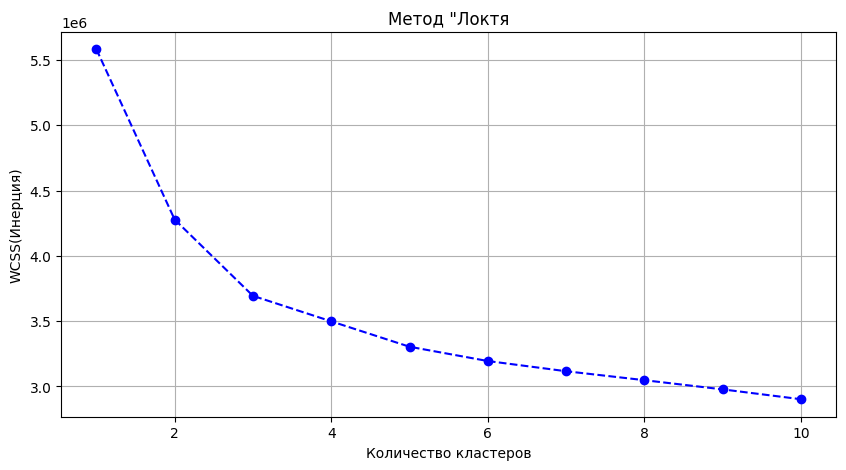

In [26]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(user_prof_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('Метод Локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS(Инерция)')
plt.grid(True)
plt.show() 

In [27]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
user_prof['km_cluster'] = kmeans.fit_predict(user_prof_scaled)

In [28]:
ratings_with_clusters = ratings.merge(user_prof[['km_cluster']], left_on='userId', right_index=True)

In [33]:
cluster_analysis = user_prof.groupby('km_cluster').median()

for i in range(optimal_k):
    count = len(user_prof[user_prof['km_cluster'] == i])
    print(f"КЛАСТЕР №{i} (Размер: {count})")
    
    top_genres = cluster_analysis.loc[i, all_genre_columns].sort_values(ascending=False).head(5)
    
    print("Медиана по оценкам:")
    for genre, score in top_genres.items():
        if score > 0:
            print(f"- {genre}: {score}")


КЛАСТЕР №0 (Размер: 34358)
Медиана по оценкам:
- Action: 3.5
- Thriller: 3.5
- Drama: 3.2
- Adventure: 3.0
- Science Fiction: 3.0
КЛАСТЕР №1 (Размер: 28570)
Медиана по оценкам:
- Drama: 2.75
- Comedy: 1.5
КЛАСТЕР №2 (Размер: 64185)
Медиана по оценкам:
- Mystery: 3.8333333333333335
- Romance: 3.75
- Thriller: 3.75
- Action: 3.7333333333333334
- Crime: 3.727272727272727
КЛАСТЕР №3 (Размер: 36009)
Медиана по оценкам:
- TV Movie: 4.0
- Mystery: 3.75
- Western: 3.75
- Action: 3.709090909090909
- Thriller: 3.706896551724138
КЛАСТЕР №4 (Размер: 67793)
Медиана по оценкам:
- Mystery: 4.0
- Science Fiction: 3.9
- Action: 3.875
- Thriller: 3.875
- Romance: 3.875
КЛАСТЕР №5 (Размер: 34933)
Медиана по оценкам:
- Romance: 4.0
- Comedy: 3.8
- Drama: 3.75
- Thriller: 3.357142857142857
- Action: 3.0


In [34]:
print("Распределение оценок в %:")
print(ratings['rating'].value_counts(normalize=True).sort_index() * 100)
genre_avg = data.groupby('genres_list')['rating'].mean().sort_values(ascending=False)
print("Средние оценки жанров(Топ-5):")
print(genre_avg.head(5))

Распределение оценок в %:
rating
0.5     1.555843
1.0     3.240473
1.5     1.550886
2.0     6.772289
2.5     4.823794
3.0    20.199292
3.5    11.974248
4.0    26.893346
4.5     8.340059
5.0    14.649772
Name: proportion, dtype: float64
Средние оценки жанров(Топ-5):
genres_list
Western      3.658921
Mystery      3.653243
Animation    3.597373
TV Movie     3.595226
Crime        3.572401
Name: rating, dtype: float64


In [37]:
def predict_movie(user_id, movie_title):
    m_info = movies[movies['title'].str.lower() == movie_title.lower()]
    if m_info.empty: return "Фильм не найден."
    movie_id = m_info.iloc[0]['id']
    movie_genres = m_info.iloc[0]['genres_list']
    
    #Поиск кластера
    if user_id not in user_prof.index: return "Пользователь не найден."
    u_cluster = user_prof.loc[user_id, 'km_cluster']
    cluster_profiles = user_prof[user_profiles['km_cluster'] == u_cluster]
    cluster_size = len(cluster_profiles)
    
    #Анализ по жанру 
    genre_stats = []
    genre_medians = []
    
    for g in movie_genres:
        if g in all_genre_columns:
            active_users = cluster_profiles[cluster_profiles[g] > 0][g]
            count_active = len(active_users)
            
            if count_active > 0:
                med = active_users.median()
                genre_medians.append(med)
                pct = (count_active / cluster_size) * 100
                genre_stats.append(f"   • {g}: оценили {count_active} чел. ({round(pct, 1)}% группы). Медиана: {med}")

    score_genres = sum(genre_medians) / len(genre_medians) if genre_medians else 0
    prob_genres = (score_genres / 5) * 100

    # Анализ по фильму
    movie_ratings_in_cluster = ratings_with_clusters[
        (ratings_with_clusters['movieId'] == movie_id) & 
        (ratings_with_clusters['km_cluster'] == u_cluster)
    ]
    
    count_voted = len(movie_ratings_in_cluster)
    percent_voted = (count_voted / cluster_size) * 100
    score_movie = movie_ratings_in_cluster['rating'].median() if count_voted > 0 else None
    prob_movie = (score_movie / 5) * 100 if score_movie is not None else None

    print(f"\n" + "="*65)
    print(f"Фильм: '{movie_title}'. Для пользователя: {user_id}")
    print(f"Кластер: №{u_cluster}. Кол-во людей в кластере: {cluster_size} чел.")
    print(f"="*65)
    
    print(f"Анализ по жанру:")
    if genre_stats:
        for stat in genre_stats: print(stat)
        print(f"Вероятность, что понравится по жанру: {round(prob_genres, 1)}%")
    else:
        print("Нет данных по жанрам в этой группе.")

    print(f"Анализ по фильму:")
    if score_movie is not None:
        print(f"Фильм оценили: {count_voted} чел. ({round(percent_voted, 2)}% группы)")
        print(f"Средняя оценка(медиана): {score_movie} из 5")
        print(f": Вероятность,что понравится по предпочтению других пользователей {round(prob_movie, 1)}%")
    else:
        print(f"Кластер не смотрела этот фильм")

    if prob_movie is not None:
        final_prob = (prob_genres + prob_movie) / 2
        print(f"Итоговая вероятность: {round(final_prob, 1)}%")
    else:
        print(f"Итоговая вероятность: {round(prob_genres, 1)}% (только по жанрам)")

predict_movie(9, "Jumanji")


Фильм: 'Jumanji'. Для пользователя: 9
Кластер: №4. Кол-во людей в кластере: 64185 чел.
Анализ по жанру:
   • Adventure: оценили 63599 чел. (99.1% группы). Медиана: 3.6666666666666665
   • Fantasy: оценили 61854 чел. (96.4% группы). Медиана: 3.7222222222222223
   • Family: оценили 60011 чел. (93.5% группы). Медиана: 3.6
Вероятность, что понравится по жанру: 73.3%
Анализ по фильму:
Фильм оценили: 3 чел. (0.0% группы)
Средняя оценка(медиана): 5.0 из 5
: Вероятность,что понравится по предпочтению других пользователей 100.0%
Итоговая вероятность: 86.6%
